# Solve *Blackjack* by Temporal Difference Control

We implement tabular Sarsa and Q-learning for Blackjack.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set()
%matplotlib inline

In [2]:
from plot_utils import draw_heatmap
from dp_tools import mean_policy_value
from easy21 import Easy21, HIT, STICK

In [3]:
env = Easy21()

## Epsilon greedy policy with decay

In [4]:
def EpsilonGreedyWithDecay(decay_rate, epsilon0):
    def epsilon_greedy_with_decay(qvalues, visits):
        epsilon = epsilon0 / (1.0 + decay_rate * sum(visits))
        n_actions = len(qvalues)
        probs = [epsilon / n_actions] * n_actions
        maxidx = qvalues.index(max(qvalues))
        probs[maxidx] += (1 - epsilon)
        return probs
    return epsilon_greedy_with_decay

In [5]:
explore_policy = EpsilonGreedyWithDecay(0.01, 1.0)

## Step size with decay

In [6]:
def StepSizeWithDecay(decay_rate, alpha0):
    def step_size_with_decay(visit, *args, **kwargs):
        return alpha0 / (1.0 + decay_rate * visit)
    return step_size_with_decay    

In [7]:
stepsize = StepSizeWithDecay(1.0, 1.0)

## Sarsa control algorithm

Sarsa control algorithm is as follows.

1. Initialize Q function.
1. Set $t=0$ and initialize $s_t$.
1. Choose $a_t$ by exploration policy to $s_t$.
1. Take action $a_t$ and obtain $(r_{t+1}, s_{t+1})$.
1. Choose action $a_{t+1}$ by exploration policy to $s_{t+1}$.
1. Update Q function by
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \cdot \left( r_{t+1} + \gamma Q\left(s_{t+1}, a_{t+1}\right) - Q(s_t, a_t) \right)$$
1. If $s_{t+1}$ is not terminal, set $t \leftarrow t+1$ and go to 4.
1. Finish if maximum number of iteration has reached, otherwise go to 2.

In [8]:
# Here, we use dict structure for Q-values, and visit counts.
# This way, we can look up the values using the state itself as the key.
# Perhaps more efficient way is to use numpy array,
# with some effort to match states and index.

def sarsa_episode(qs, ns, env, policy, stepsize, gamma):
    s = env.reset()
    if s not in qs:
        qs[s] = [0.0] * env.num_actions
        ns[s] = [0.0] * env.num_actions

    prob = policy(qs[s], ns[s])
    a = random.choices(range(env.num_actions), prob)[0]
    while True:
        s1, r, done, _ = env.step(a)
        alpha = stepsize(ns[s][a])
        
        if done:
            qs[s][a] += alpha * (r - qs[s][a])
            ns[s][a] += 1.0
            break
        else:
            if s1 not in qs:
                qs[s1] = [0.0] * env.num_actions
                ns[s1] = [0.0] * env.num_actions
            prob = policy(qs[s1], ns[s1])
            a1 = random.choices(range(env.num_actions), prob)[0]
            qs[s][a] += alpha * (r + gamma * qs[s1][a1] - qs[s][a])
            ns[s][a] += 1.0
            s, a = s1, a1

In [9]:
qs = {}
ns = {}

In [10]:
for i in tqdm(range(10**6)):
    sarsa_episode(qs, ns, env, explore_policy, stepsize, gamma=1.0)

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_16880/3087285553.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [11]:
def to_state_value(qs):
    v = np.zeros((21, 10))
    for s, q in qs.items():
        player, dealer = s
        v[player-1, dealer-1] = max(q)
    return v

def to_policy(qs):
    policy = np.zeros((21, 10), dtype=int)
    for s, q in qs.items():
        player, dealer = s
        policy[player-1, dealer-1] = q.index(max(q))
    return policy

def to_q_array(qs):
    q_array = np.zeros((21, 10, 2))
    for s, q in qs.items():
        player, dealer = s
        q_array[player-1, dealer-1] = q
    return q_array

def to_q_diff(qs):
    q_array = to_q_array(qs)
    return q_array[:,:,1] - q_array[:,:,0]

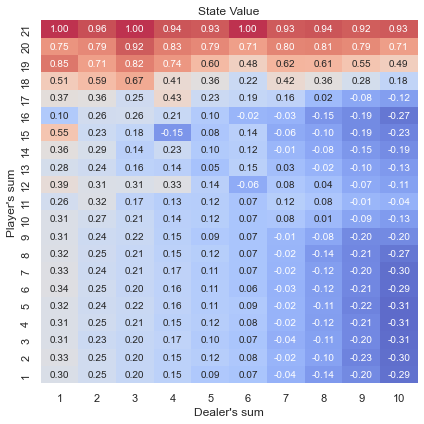

In [12]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

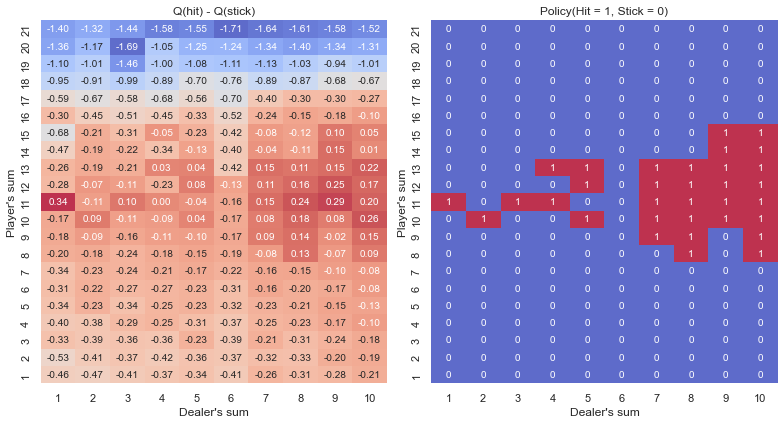

In [13]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

*Remark: The sarsa result looks closer to DP than Mante Carlo control at 10^6-th iteration.*

## Comparison to the DP result

We will now compare the monte carlo control results with that of dynamic programming.
Here, we regard the DP result as "correct"; Since it has been already converged to the fixed point of the Bellman optimality equation, it is the solution (unless there is a bug in the DP implementation).

Every 1000 iteration, we will calculate the mean absolute difference between two Q-functions, and see how this "error" changes along the iterations.  We also calculate the average value for the player *before* the game starts, as an evaluation of the trained policy.

In [14]:
f = np.load("result/dp.npz")
Q_dp = f["Q"]
print(Q_dp.shape)
mean_value_dp = f["mean_value"]

(21, 10, 2)


In [15]:
qs = {}
ns = {}
maes = []
values = []

In [16]:
for i in tqdm(range(10**6)):
    sarsa_episode(qs, ns, env, explore_policy, stepsize, gamma=1.0)
    if (i + 1) % 1000 == 0:
        q_array = to_q_array(qs)
        maes.append(np.mean(np.abs(q_array - Q_dp)))
        values.append(mean_policy_value(to_policy(qs), gamma=1.0))

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_16880/2987607636.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

Final error = 0.08098514315867088
Final value = 0.054942484789465576


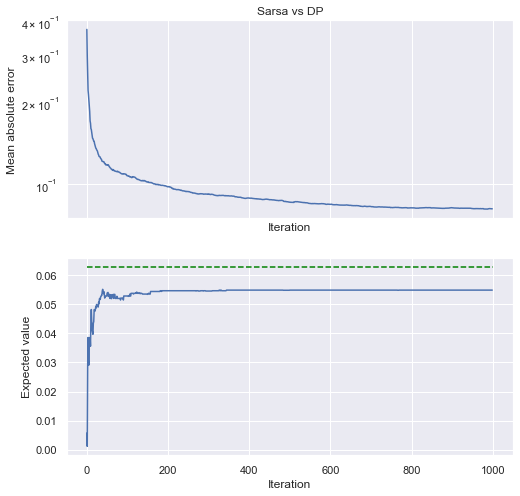

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax1.plot(maes)
ax1.set_yscale("log")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Mean absolute error")
ax1.set_title("Sarsa vs DP")

ax2.plot(values)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Expected value")
ax2.hlines(mean_value_dp, 0, len(values), linestyles="--", color="green")
print("Final error =", maes[-1])
print("Final value =", values[-1])

*Remark: The "error" is decreasing along the iteration, but it seems to have still a long way until complete convergence.*

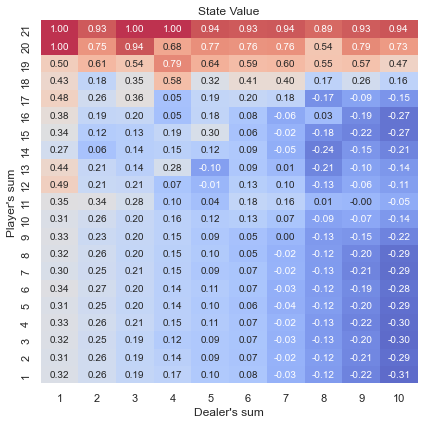

In [18]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

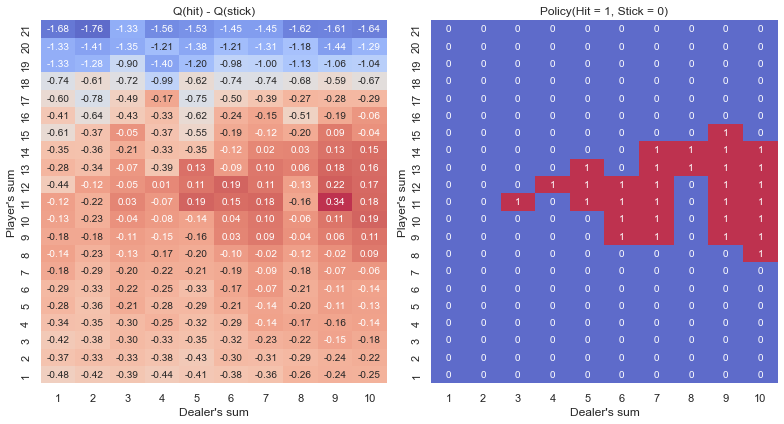

In [19]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

## Q-learning control

Q-learning control algorithm is as follows.

1. Initialize Q function.
1. Set $t=0$ and initialize $s_t$.
1. Choose $a_t$ by exploration policy to $s_t$.
1. Take action $a_t$ and obtain $(r_{t+1}, s_{t+1})$.
1. Update Q function by
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \cdot \left( r_{t+1} + \gamma \max_a Q\left(s_{t+1}, a\right) - Q(s_t, a_t) \right)$$
1. If $s_{t+1}$ is not terminal, set $t \leftarrow t+1$ and go to 3.
1. Finish if maximum number of iteration has reached, otherwise go to 2.

In [20]:
def qlearn_episode(qs, ns, env, policy, stepsize, gamma):
    s = env.reset()
    while True:
        if s not in qs:
            qs[s] = [0.0] * env.num_actions
            ns[s] = [0.0] * env.num_actions

        prob = policy(qs[s], ns[s])
        a = random.choices(range(env.num_actions), prob)[0]
        
        s1, r, done, _ = env.step(a)
        alpha = stepsize(ns[s][a])
        
        if done:
            qs[s][a] += alpha * (r - qs[s][a])
            ns[s][a] += 1.0
            break
        else:
            if s1 not in qs:
                qs[s1] = [0.0] * env.num_actions
                ns[s1] = [0.0] * env.num_actions
            qs[s][a] += alpha * (r + gamma * max(qs[s1]) - qs[s][a])
            ns[s][a] += 1.0
            s = s1

In [21]:
qs = {}
ns = {}

In [22]:
for i in tqdm(range(10**6)):
    qlearn_episode(qs, ns, env, explore_policy, stepsize, gamma=1.0)

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_16880/795250689.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

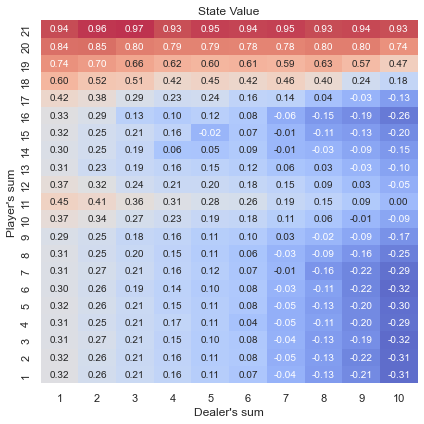

In [23]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

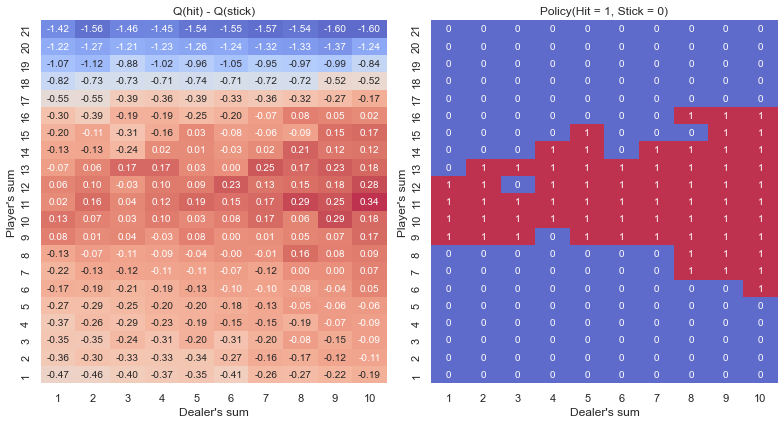

In [24]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

## Comparison to the DP result

In [25]:
qs = {}
ns = {}
maes = []
values = []

In [26]:
for i in tqdm(range(10**6)):
    qlearn_episode(qs, ns, env, explore_policy, stepsize, gamma=1.0)
    if (i + 1) % 1000 == 0:
        q_array = to_q_array(qs)
        maes.append(np.mean(np.abs(q_array - Q_dp)))
        values.append(mean_policy_value(to_policy(qs), gamma=1.0))

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_16880/1575610607.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(10**6)):


  0%|          | 0/1000000 [00:00<?, ?it/s]

Final error = 0.02774383176158712
Final value = 0.05996815848137839


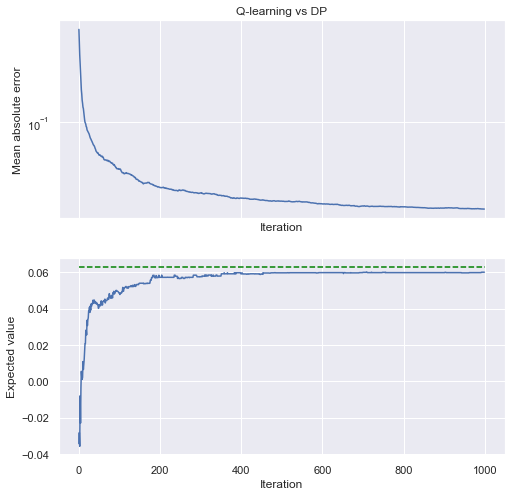

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax1.plot(maes)
ax1.set_yscale("log")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Mean absolute error")
ax1.set_title("Q-learning vs DP")

ax2.plot(values)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Expected value")
ax2.hlines(mean_value_dp, 0, len(values), linestyles="--", color="green")
print("Final error =", maes[-1])
print("Final value =", values[-1])

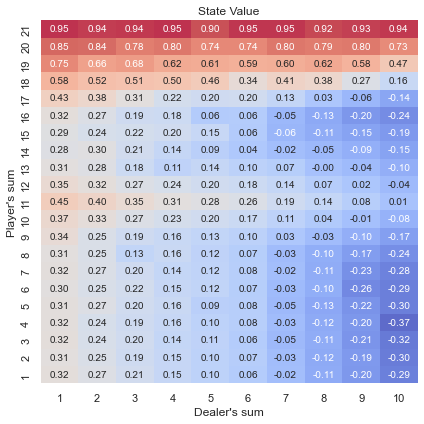

In [28]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

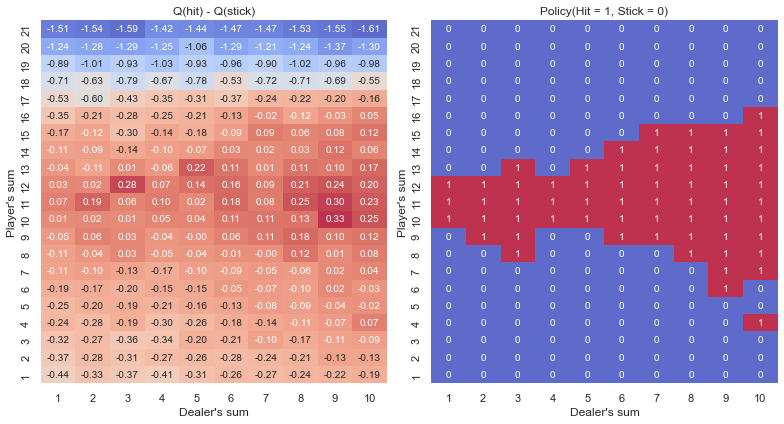

In [29]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

*Remark: In this example, Q-learning tends to converge to the "correct" value faster than Sarsa and monte carlo control.*